In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from numpy.fft import fft

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (30, 20)

In [35]:
## process_file() takes a string with a path to the .csv
def process_file(pathname):
    res = pd.read_csv(pathname, sep = ',', header = 0, index_col = None, names = ['time', 'seconds', 'z', 'y', 'x'])
    return res

## butterworth() takes a dataframe with our accelerometer data and applies the Butterworth filter to it. 
## The columns of the DF is overwritten by the filtered values.
## Sources: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html 
##               https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butterworth(df):
    nyquist_frequency = 0.5 * 50
    
    low = 0.5 / nyquist_frequency
    high = 3.0 / nyquist_frequency
    
    b, a = signal.butter(3, Wn=[low, high], btype='bandpass')

    df['x'] = signal.filtfilt(b, a, df['x'])
    df['y'] = signal.filtfilt(b, a, df['y'])
    df['z'] = signal.filtfilt(b, a, df['z'])

    return df

## fourier() takes a dataframe with our filtered accelerometer data and produces a new dataframe with x, y pairs.
## This produces the Fourier-transformed data. (I assume)
## Sources: https://stackoverflow.com/questions/66675657/fast-fourier-transform-for-an-accelerometer-in-python
def fourier(df):
    yf = np.abs(fft(df['x'] + df['y'] + df['z']))
    xf = np.linspace(0, diego_lp50.shape[0] / 60, len(yf))

    return pd.DataFrame(zip(xf, yf), columns = ['x', 'y'])

## to_row() takes a Fourier-transformed dataframe and transposes its 'y' column into a row.
## This makes it possible to pass the transformed dataframe into an ML model.
def to_row(df, name):
    df = df.T
    df.drop('x', inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.insert(loc = 0, column = 'Name', value = name)

    return df
    

In [38]:
# Processing .csv files, passing them through Butterworth filter, and Fourier transforming them

# Diego
diego_lp50 = butterworth(process_file('data/diego_lp50.csv'))
diego_rp50 = butterworth(process_file('data/diego_rp50.csv'))
diego_lp50 = diego_lp50[(diego_lp50['seconds'] <= 60)]
diego_rp50 = diego_rp50[(diego_rp50['seconds'] <= 60)]
d_lp50fourier = fourier(diego_lp50)
d_rp50fourier = fourier(diego_rp50)

# Matt
matt_lp50 = butterworth(process_file('data/matt_lp50.csv'))
matt_rp50 = butterworth(process_file('data/matt_rp50.csv'))
matt_lp50 = matt_lp50[(matt_lp50['seconds'] >= 5) & (matt_lp50['seconds'] <= 65)] 
matt_rp50 = matt_rp50[(matt_rp50['seconds'] >= 5) & (matt_rp50['seconds'] <= 65)] 
m_lp50fourier = fourier(matt_lp50)
m_rp50fourier = fourier(matt_rp50)

# Sam
sam_lp50 = butterworth(process_file('data/sam_lp50.csv'))
sam_rp50 = butterworth(process_file('data/sam_rp50.csv'))
sam_lp50 = sam_lp50[(sam_lp50['seconds'] >= 33) & (sam_lp50['seconds'] <= 93)]
sam_rp50 = sam_rp50[(sam_rp50['seconds'] >= 33) & (sam_rp50['seconds'] <= 93)]
s_lp50fourier = fourier(sam_lp50)
s_rp50fourier = fourier(sam_rp50)

##### 5-MINUTE DATA

dlp_5min = butterworth(process_file('data/5minlp.csv'))
drp_5min = butterworth(process_file('data/5minrp.csv'))
dlp_5min = dlp_5min[(dlp_5min['seconds'] >= 30) & (dlp_5min['seconds'] <= 330)]
drp_5min = drp_5min[(drp_5min['seconds'] >= 30) & (drp_5min['seconds'] <= 330)]
dlp5m_f = fourier(dlp_5min)
drp5m_f = fourier(drp_5min)

mrp_5min = butterworth(process_file('data/matt_rp50_5mins.csv'))
mrp_5min = mrp_5min[(mrp_5min['seconds'] >= 30) & (mrp_5min['seconds'] <= 330)]
mrp5m_f = fourier(mrp_5min)


# Butterworth Filter

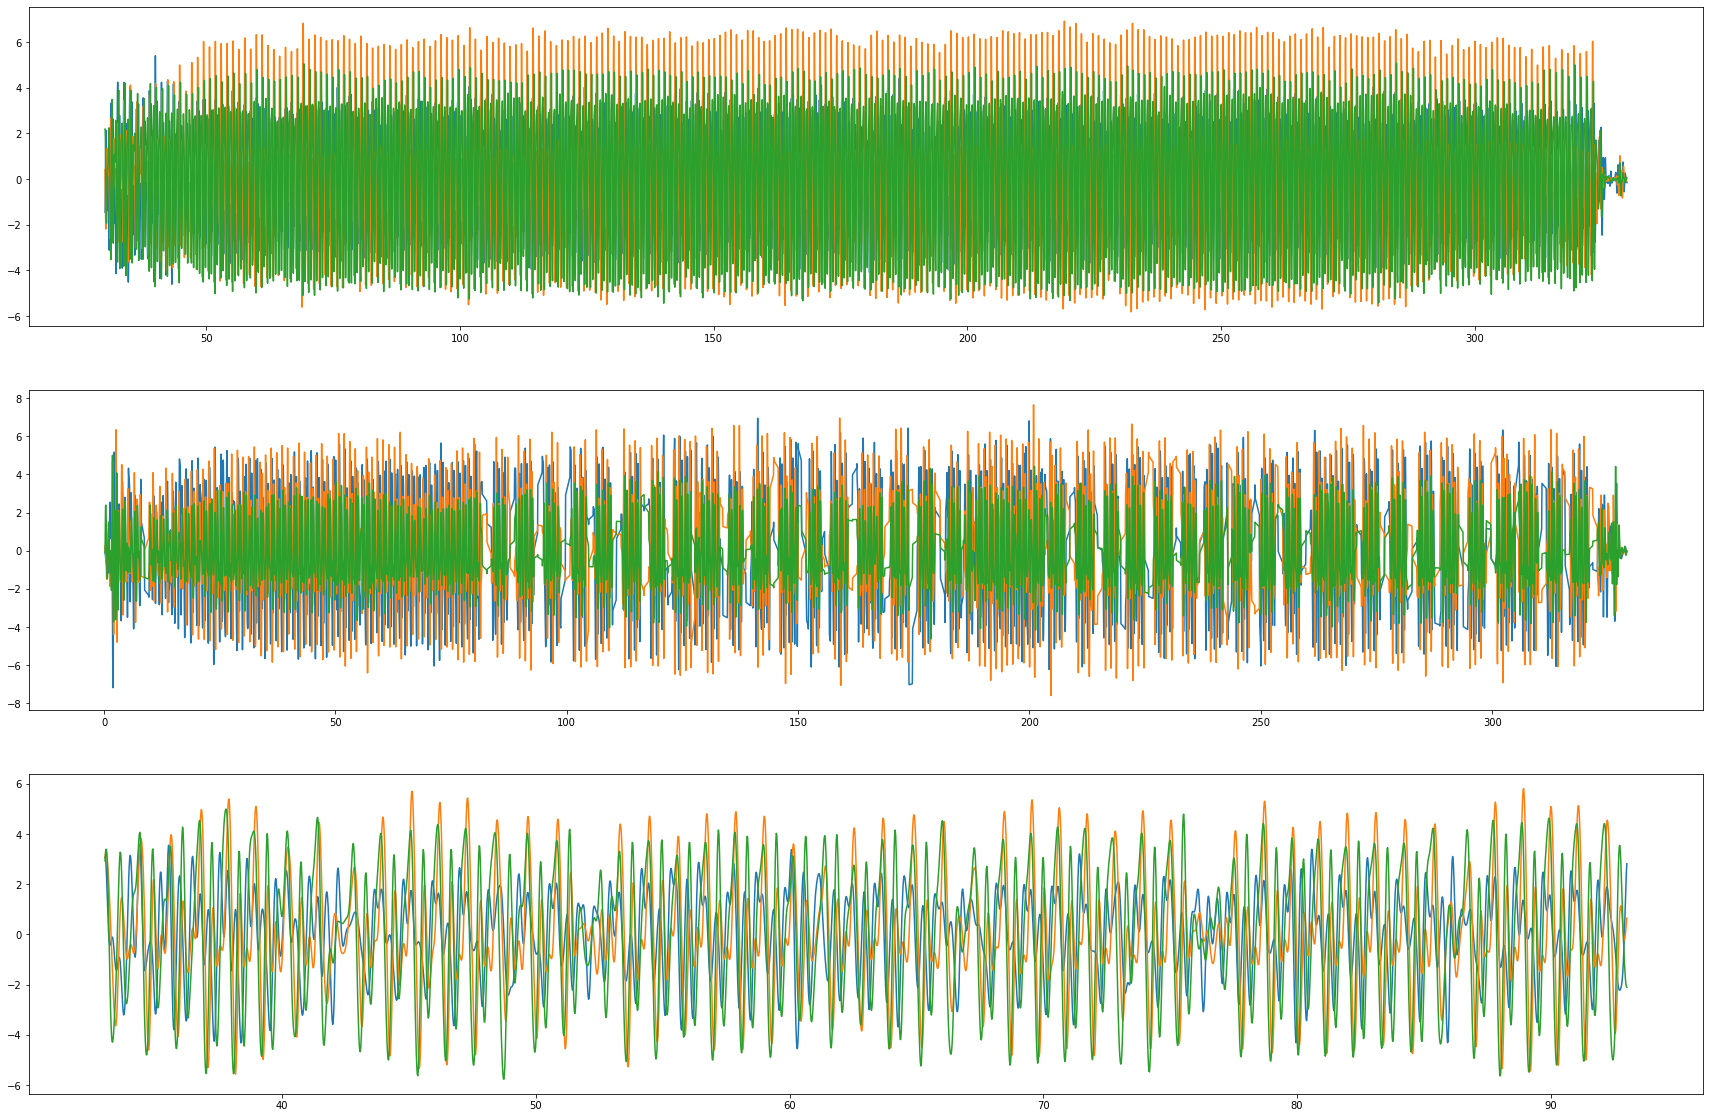

In [37]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(3)

# Diego
#ax[0].plot(diego_lp50['seconds'], diego_lp50['x'])
#ax[0].plot(diego_lp50['seconds'], diego_lp50['y'])
#ax[0].plot(diego_lp50['seconds'], diego_lp50['z'])
ax[0].plot(dlp_5min['seconds'], dlp_5min['x'])
ax[0].plot(dlp_5min['seconds'], dlp_5min['y'])
ax[0].plot(dlp_5min['seconds'], dlp_5min['z'])

# Matt
#ax[1].plot(matt_lp50['seconds'], matt_lp50['x'])
#ax[1].plot(matt_lp50['seconds'], matt_lp50['y'])
#ax[1].plot(matt_lp50['seconds'], matt_lp50['z'])
ax[1].plot(mrp_5min['seconds'], mrp_5min['x'])
ax[1].plot(mrp_5min['seconds'], mrp_5min['y'])
ax[1].plot(mrp_5min['seconds'], mrp_5min['z'])

# Sam
ax[2].plot(sam_lp50['seconds'], sam_lp50['x'])
ax[2].plot(sam_lp50['seconds'], sam_lp50['y'])
ax[2].plot(sam_lp50['seconds'], sam_lp50['z'])

# Fourier Transform

(0.0, 1.0)

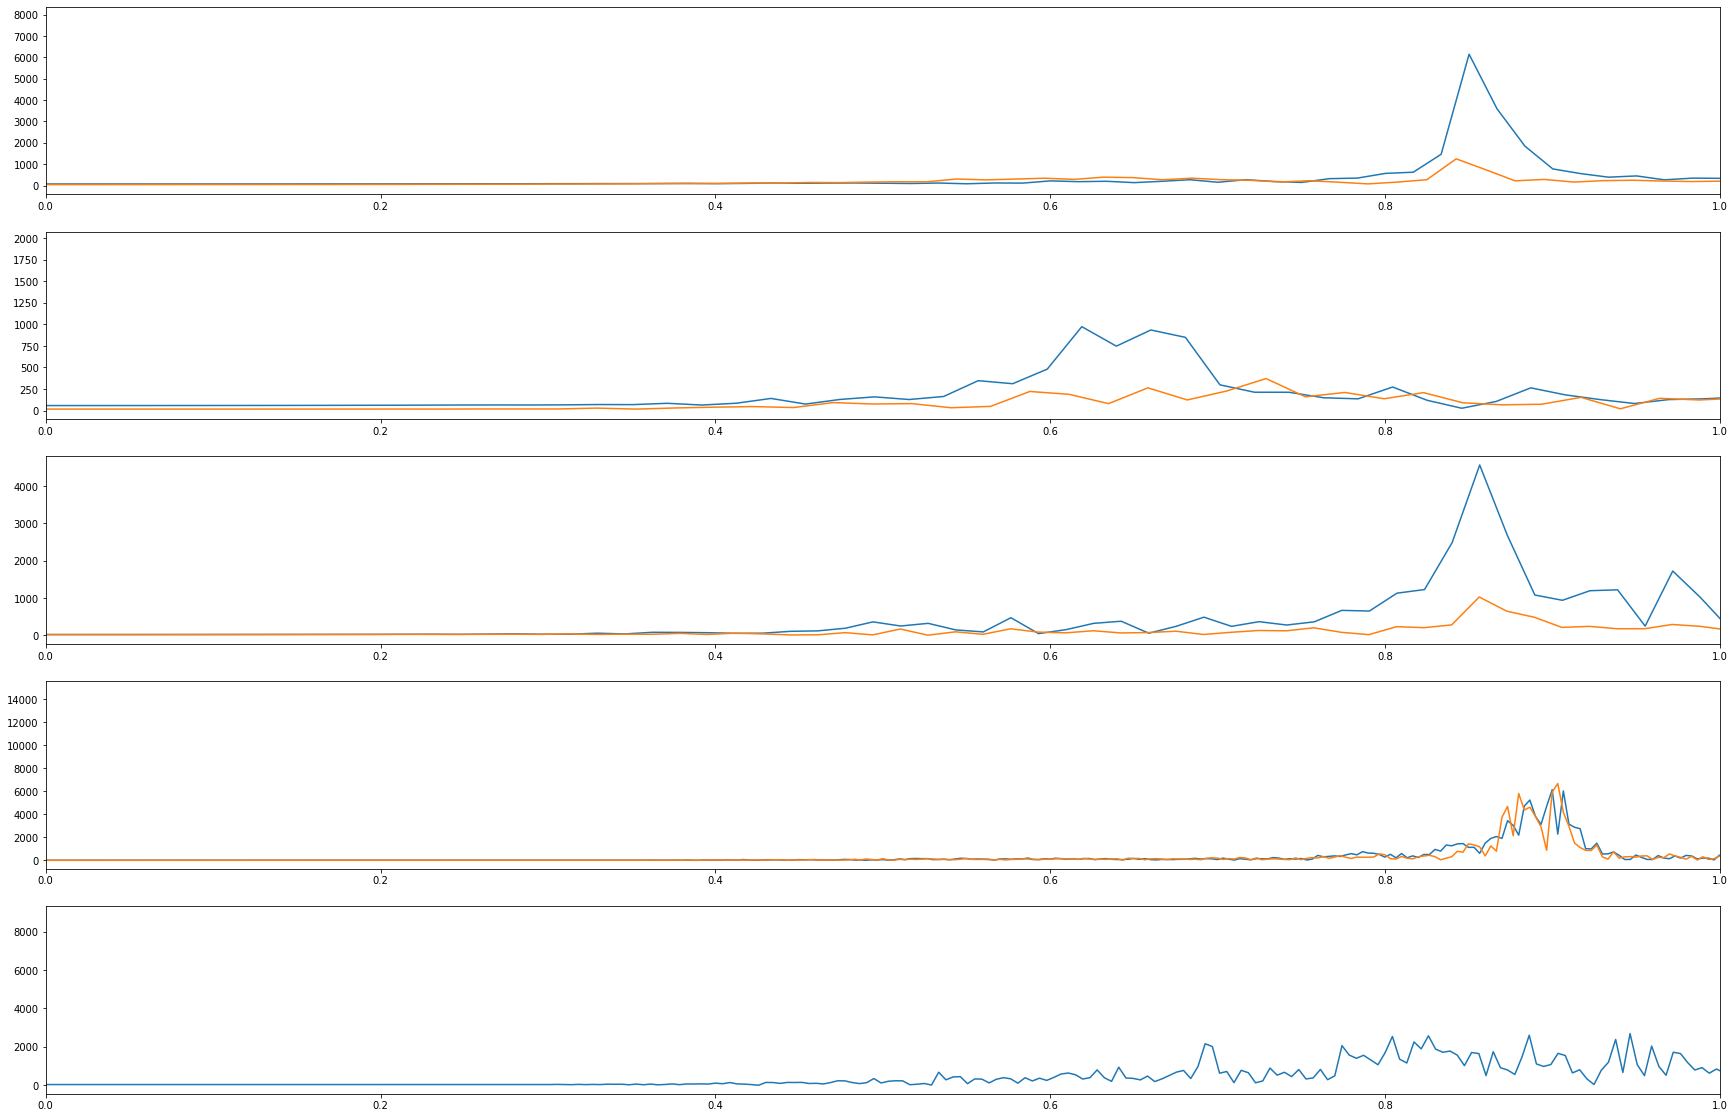

In [39]:
# Plotting Fourier transformed data. Each line represents a collection point (left pocket vs. right pocket).
fig, ax = plt.subplots(5)

# Diego
ax[0].plot(d_lp50fourier['x'], d_lp50fourier['y'])
ax[0].plot(d_rp50fourier['x'], d_rp50fourier['y'])
ax[0].set_xlim(0, 1)

# Matt
ax[1].plot(m_lp50fourier['x'], m_lp50fourier['y'])
ax[1].plot(m_rp50fourier['x'], m_rp50fourier['y'])
ax[1].set_xlim(0, 1)

# Sam
ax[2].plot(s_lp50fourier['x'], s_lp50fourier['y'])
ax[2].plot(s_rp50fourier['x'], s_rp50fourier['y'])
ax[2].set_xlim(0, 1)

# Diego 5min
ax[3].plot(dlp5m_f['x'], dlp5m_f['y'])
ax[3].plot(drp5m_f['x'], drp5m_f['y'])
ax[3].set_xlim(0, 1)

# Matt 5min
ax[4].plot(mrp5m_f['x'], mrp5m_f['y'])
ax[4].set_xlim(0, 1)

# Machine Learning

In [ ]:
## This codeblock is currently not working.
'''''
d_lp50tr = to_row(d_lp50fourier, 'Diego')
d_rp50tr = to_row(d_rp50fourier, 'Diego')
m_lp50tr = to_row(m_lp50fourier, 'Matt')
m_rp50tr = to_row(m_rp50fourier, 'Matt')
s_lp50tr = to_row(s_lp50fourier, 'Sam')
s_rp50tr = to_row(s_rp50fourier, 'Sam')

training_data = pd.concat([d_lp50tr, m_lp50tr, s_lp50tr, d_rp50tr, m_rp50tr, s_rp50tr])
training_data = training_data.dropna(axis = 'columns')

X = training_data.drop(columns = ['Name'])
y = training_data['Name']

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

bayes_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 2)
)

nn_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (16,8,4), activation = 'logistic', max_iter=100000)
)

dt_model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth = 125)
)

rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators = 1200 , max_depth = 5, min_samples_leaf = 8)
)

bayes_model.fit(X_train, y_train)
print(bayes_model.score(X_valid, y_valid))

knn_model.fit(X_train, y_train)
print(knn_model.score(X_valid, y_valid))

nn_model.fit(X_train, y_train)
print(nn_model.score(X_valid, y_valid))

dt_model.fit(X_train, y_train)
print(dt_model.score(X_valid, y_valid))

rf_model.fit(X_train, y_train)
print(rf_model.score(X_valid, y_valid))
'''''


(0.0, 1.0)

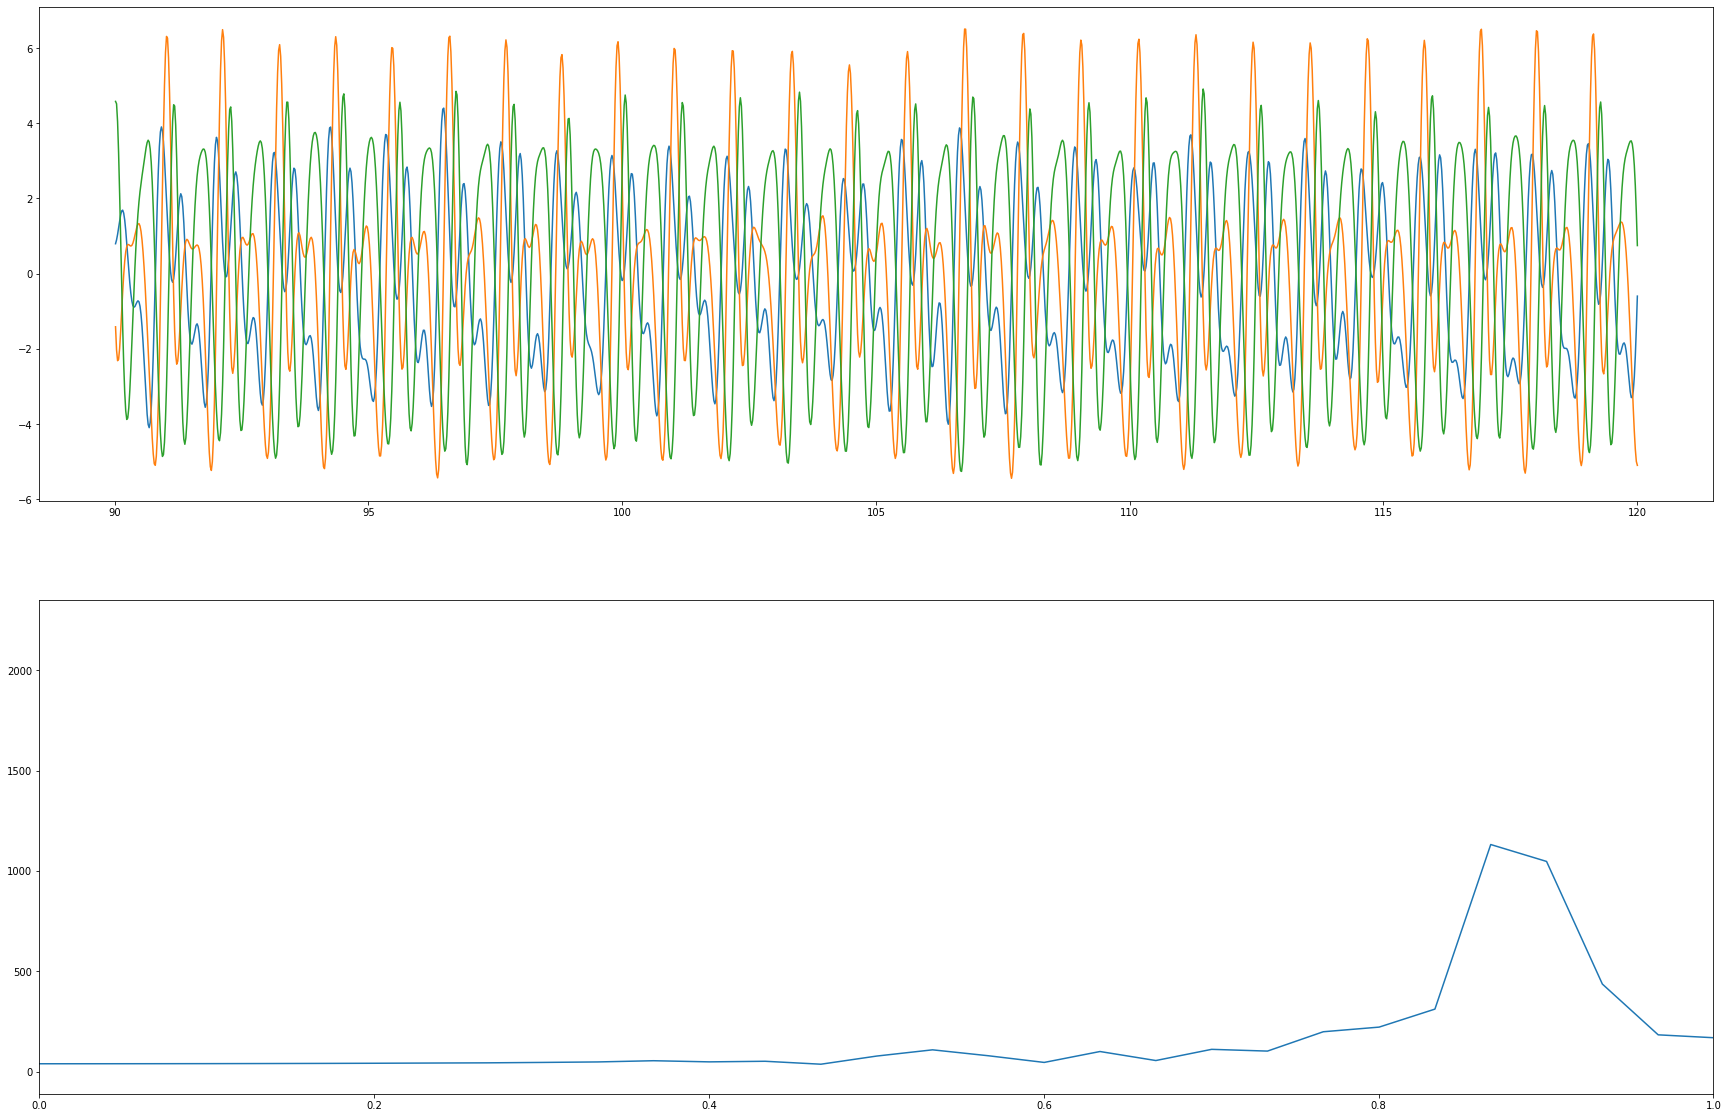

In [51]:
# Splitting the 5-minute dataset into 10 equal parts.
split = np.array_split(dlp_5min, 10)

fig, ax = plt.subplots(2)

# Accelerometer graph
ax[0].plot(split[2]['seconds'], split[5]['x'])
ax[0].plot(split[2]['seconds'], split[5]['y'])
ax[0].plot(split[2]['seconds'], split[5]['z'])

# Fourier-transforming a subset of the 5-minute dataset
split2f = fourier(split[2])

# Frequency graph
ax[1].plot(split2f['x'], split2f['y'])
ax[1].set_xlim(0,1)